Shape of Dataset: (7789, 11)

Columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']

Missing Values:
 Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64

Category Distribution:
 Category
Movie      5379
TV Show    2410
Name: count, dtype: int64

Top 5 Countries:
 Country
United States     2556
India              923
Unknown            507
United Kingdom     397
Japan              226
Name: count, dtype: int64

Dataset covers years from 2008.0 to 2021.0


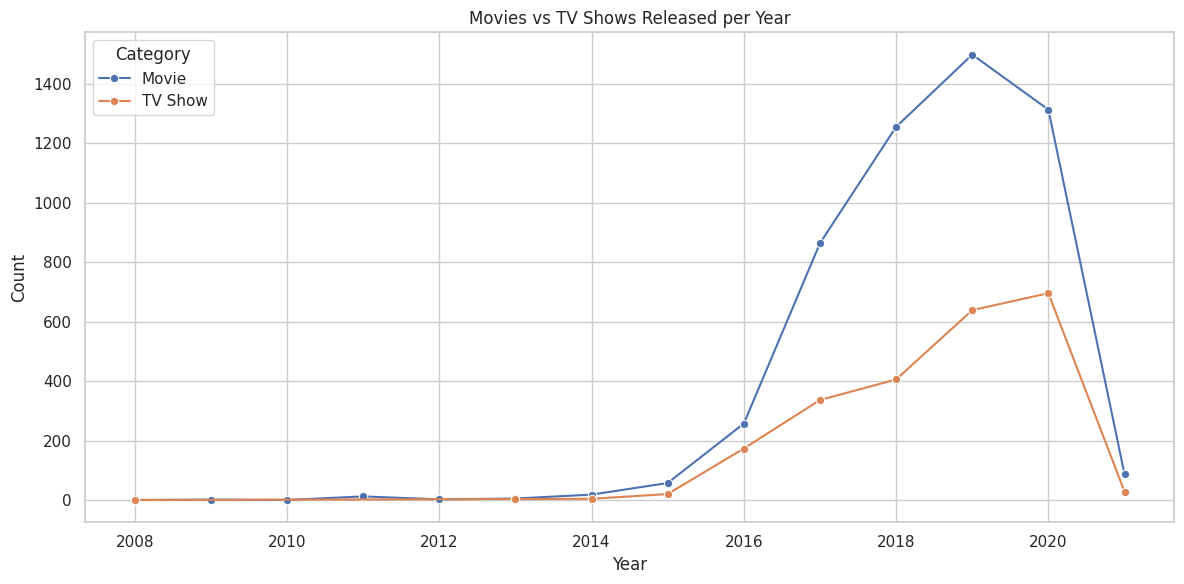

/tmp/ipython-input-4058367723.py:96: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




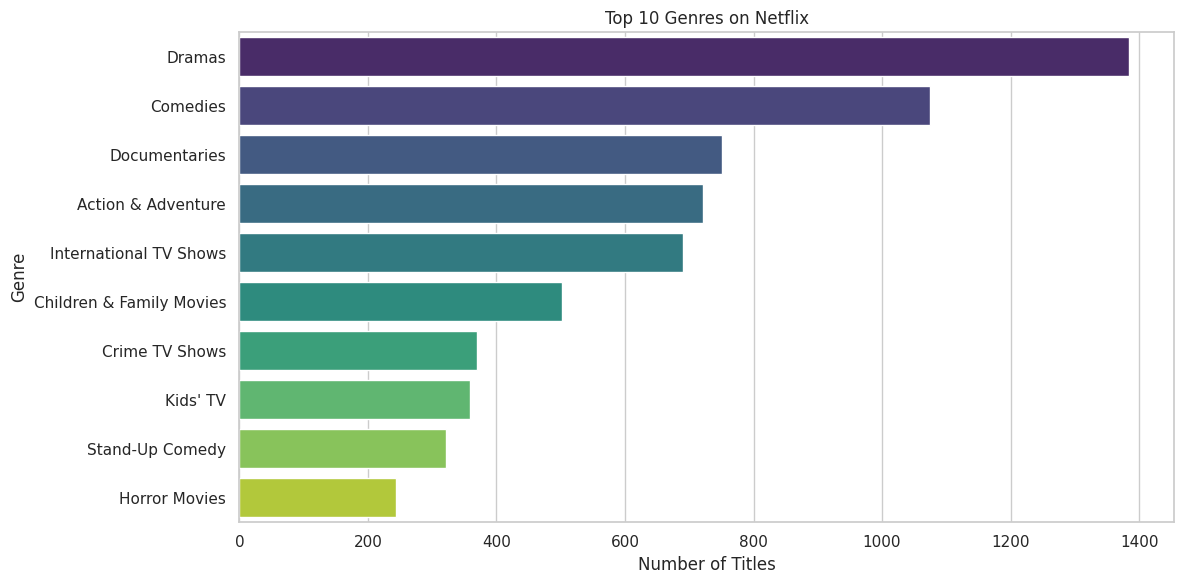

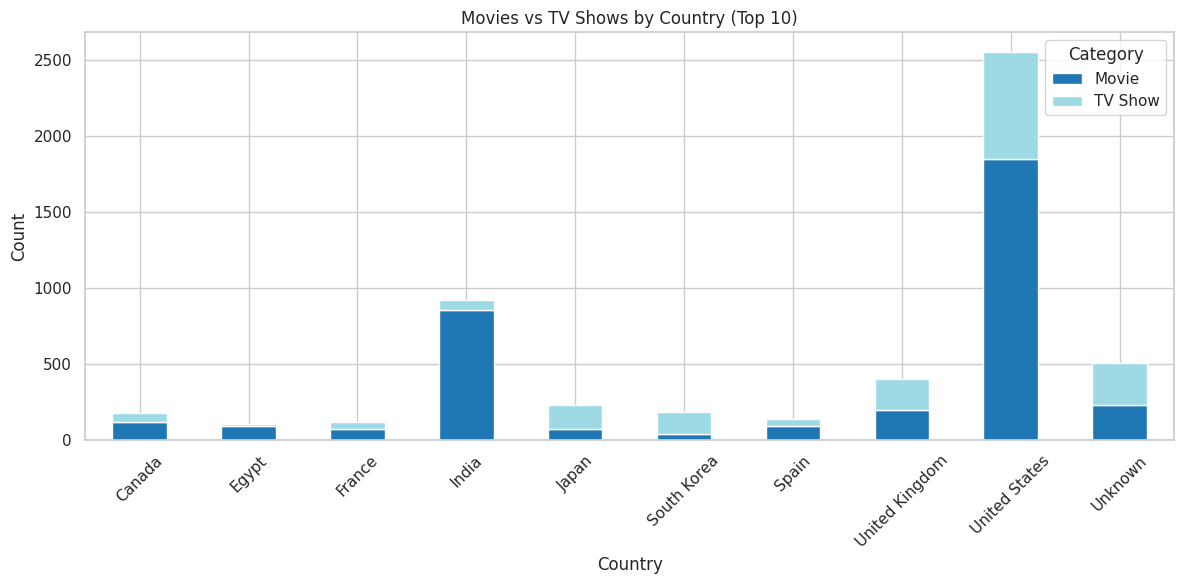

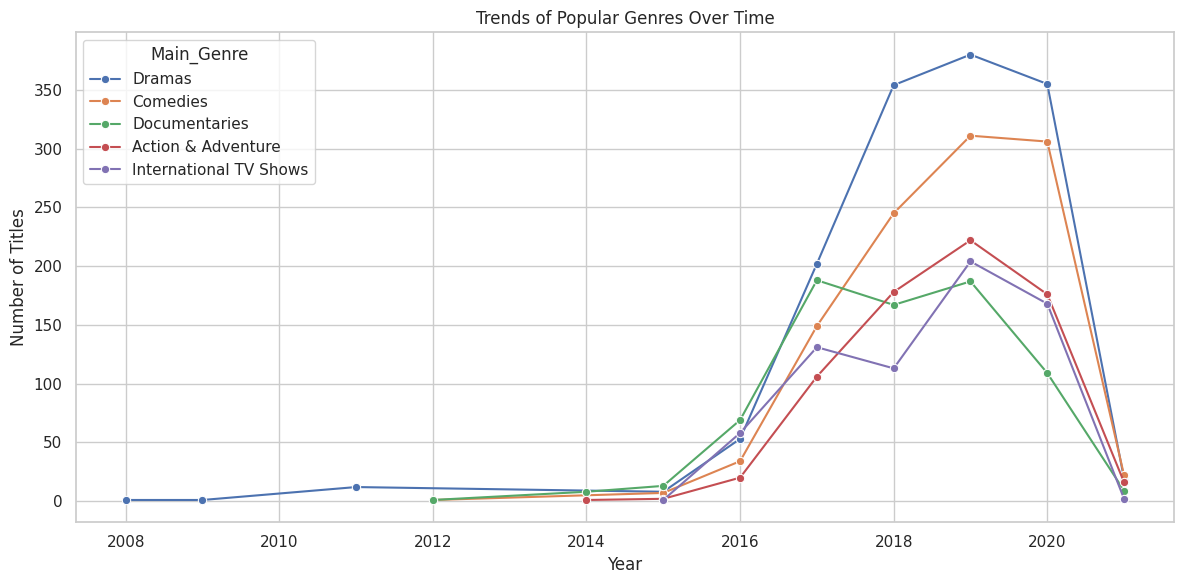

/tmp/ipython-input-4058367723.py:132: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




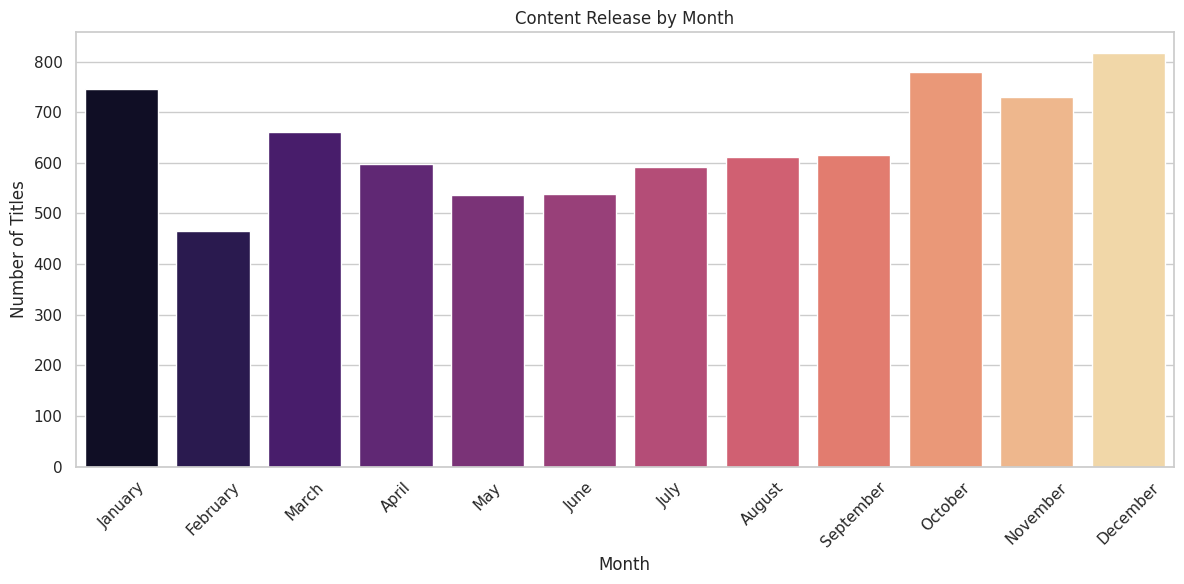

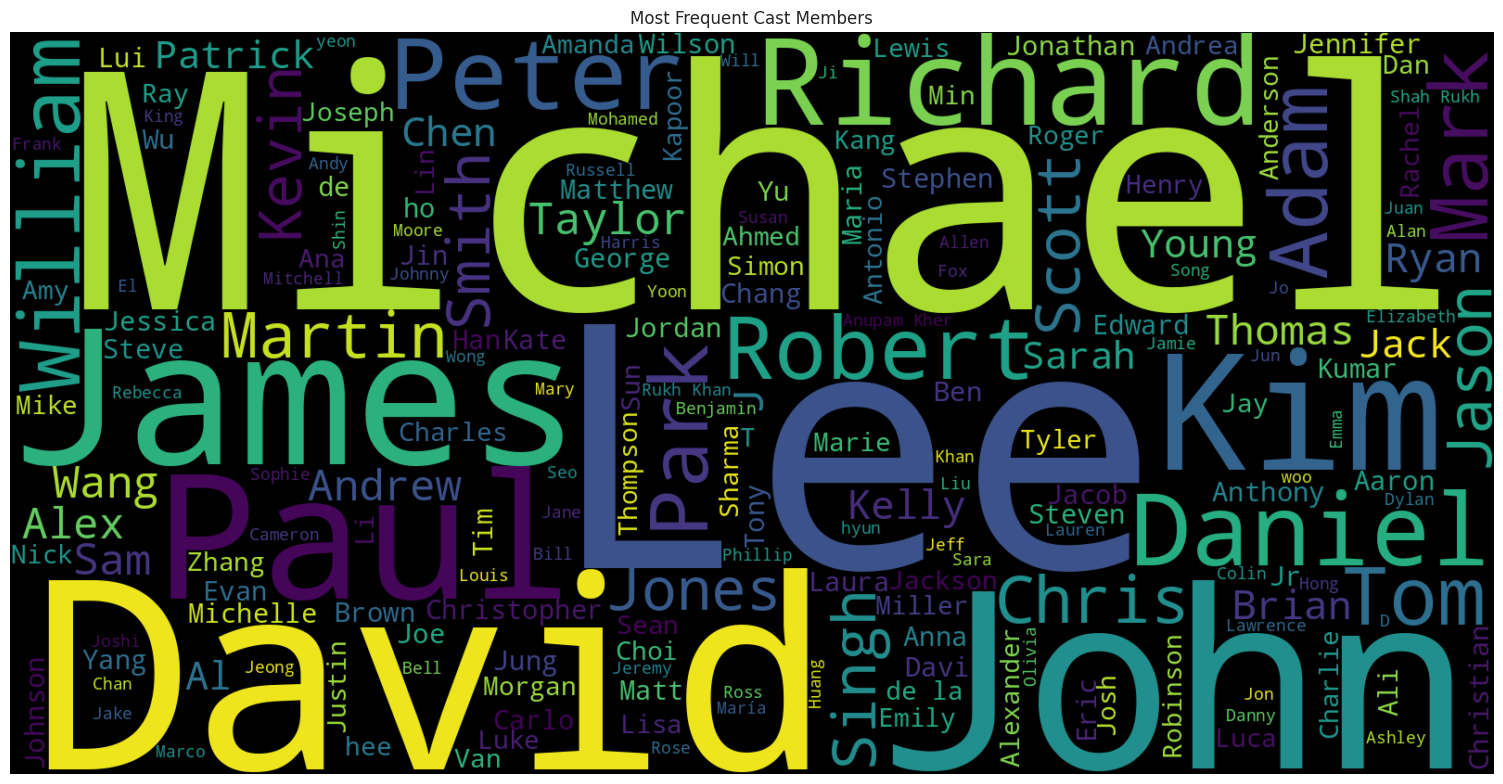

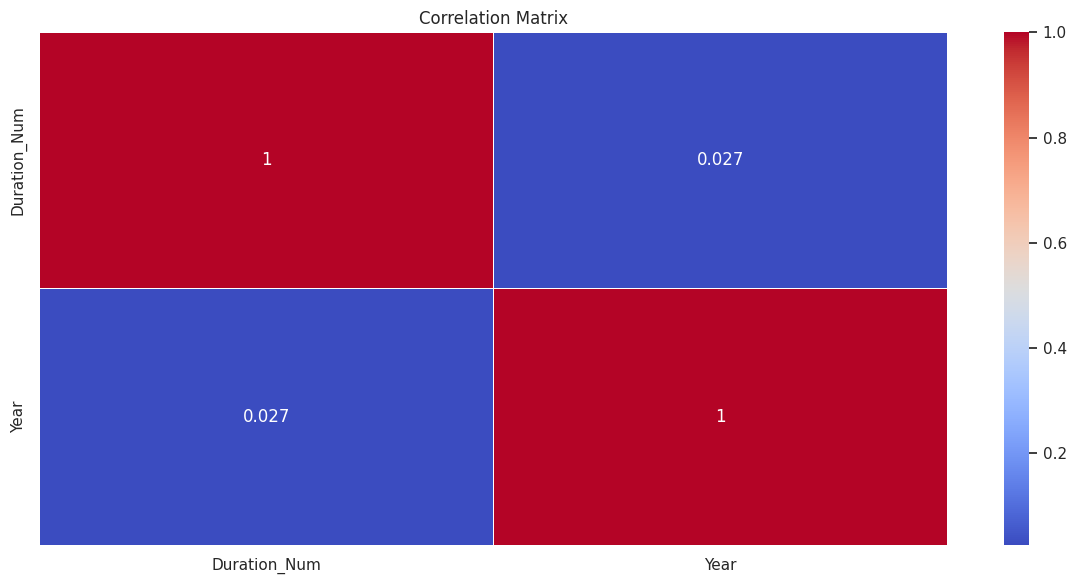

/tmp/ipython-input-4058367723.py:156: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




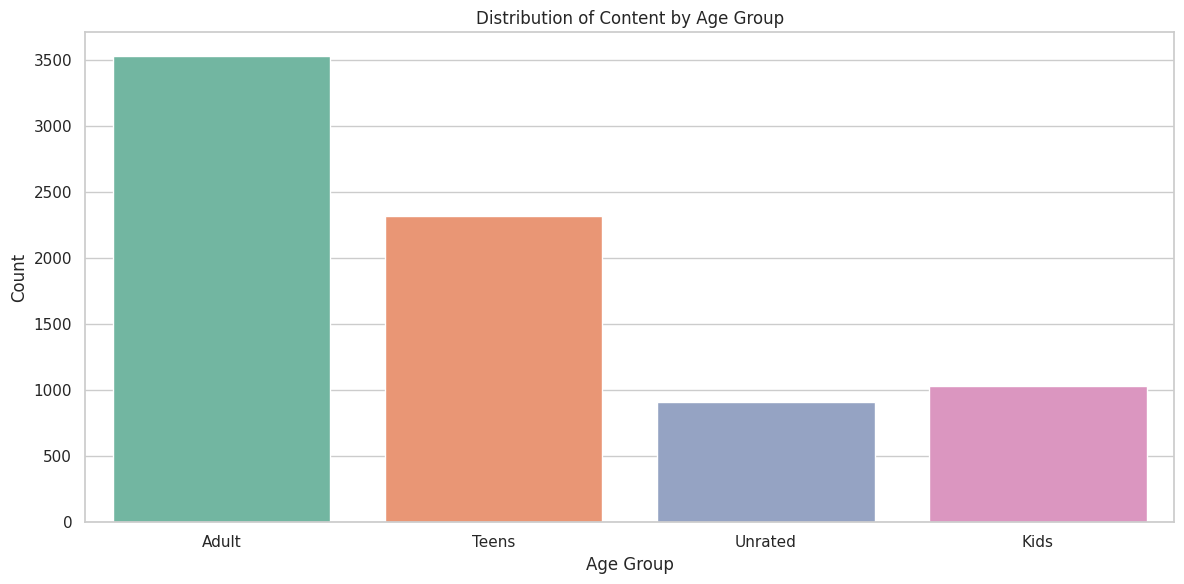

/tmp/ipython-input-4058367723.py:165: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




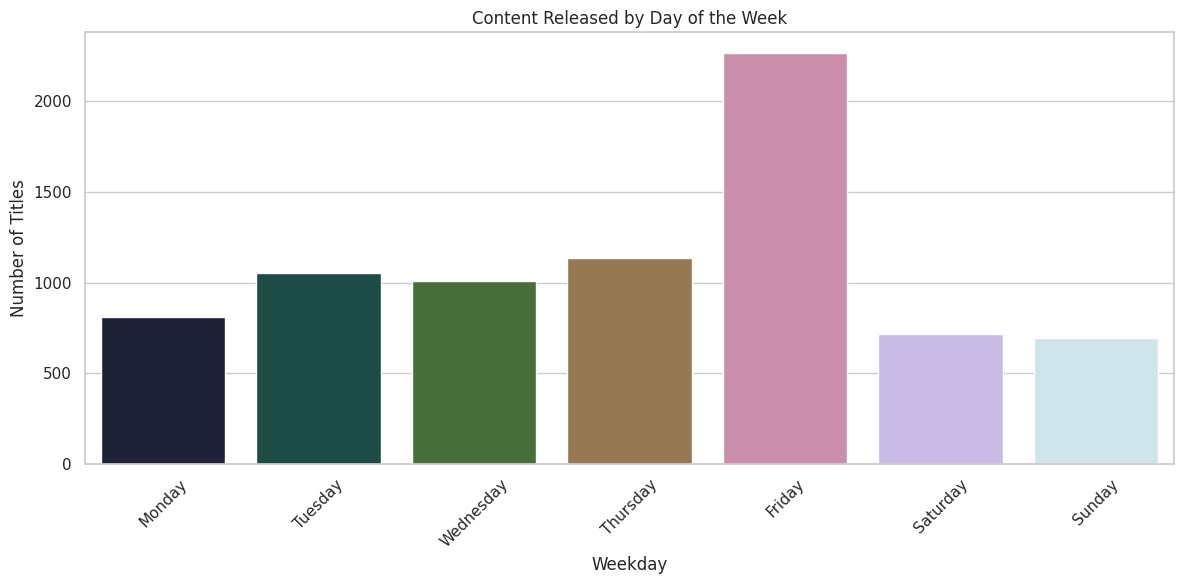


✅ All plots have been saved in the 'plots/' folder.


In [3]:
# -------------------------------------------------------
# Netflix Dataset Analysis - Problem Statement 1
# Enhanced Content Trends Analysis for Strategic Recommendations
# -------------------------------------------------------

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import os
import calendar

# Setup visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# -------------------------------------------------------
# 2. Load Dataset
# -------------------------------------------------------
df = pd.read_csv("Netflix Dataset.csv")

# Create folder for saving plots
os.makedirs("plots", exist_ok=True)

# Quick look at dataset
print("Shape of Dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())

# -------------------------------------------------------
# 3. Data Cleaning & Feature Engineering
# -------------------------------------------------------

# Convert to datetime
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')
df['Year'] = df['Release_Date'].dt.year
df['Month'] = df['Release_Date'].dt.month
df['Month_Name'] = df['Release_Date'].dt.month_name()
df['Day'] = df['Release_Date'].dt.day
df['Weekday'] = df['Release_Date'].dt.day_name()

# Fill missing values
df.fillna({'Director': 'Unknown', 'Cast': 'Unknown', 'Country': 'Unknown', 'Rating': 'Not Rated'}, inplace=True)

# Extract Main Genre (based on Description if needed)
df['Main_Genre'] = df['Type'].apply(lambda x: x.split(",")[0].strip() if pd.notnull(x) else "Unknown")

# Clean Duration column
df['Duration_Num'] = df['Duration'].str.extract(r'(\d+)').astype(float)
df['Duration_Type'] = df['Duration'].str.extract(r'([a-zA-Z]+)').fillna('Unknown')

# Classify content into broad age groups (if 'Rating' exists)
def age_group(rating):
    if rating in ['TV-MA', 'R', 'NC-17']:
        return 'Adult'
    elif rating in ['TV-14', 'PG-13']:
        return 'Teens'
    elif rating in ['TV-G', 'PG', 'TV-Y', 'TV-Y7', 'G']:
        return 'Kids'
    else:
        return 'Unrated'

df['Age_Group'] = df['Rating'].apply(age_group)

# -------------------------------------------------------
# 4. Exploratory Data Analysis (EDA)
# -------------------------------------------------------

print("\nCategory Distribution:\n", df['Category'].value_counts())
print("\nTop 5 Countries:\n", df['Country'].value_counts().head(5))
print("\nDataset covers years from", df['Year'].min(), "to", df['Year'].max())

# -------------------------------------------------------
# 5. Visual Analysis (With Saving)
# -------------------------------------------------------

# Helper function to show and save plots
def save_and_show_plot(filename):
    plt.tight_layout()
    plt.savefig(f"plots/{filename}", dpi=300, bbox_inches='tight')
    plt.show()

# 1. Movies vs. TV Shows over Years
content_trend = df.groupby(['Year', 'Category']).size().reset_index(name='Count')
sns.lineplot(data=content_trend, x='Year', y='Count', hue='Category', marker='o')
plt.title("Movies vs TV Shows Released per Year")
plt.xlabel("Year")
plt.ylabel("Count")
save_and_show_plot("movies_vs_tvshows_per_year.png")

# 2. Top 10 Main Genres
top_genres = df['Main_Genre'].value_counts().head(10)
sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
save_and_show_plot("top_10_genres.png")

# 3. Stacked Bar – Movies vs TV Shows by Top 10 Countries
top_countries = df['Country'].value_counts().head(10).index
country_data = df[df['Country'].isin(top_countries)]
stacked = country_data.groupby(['Country', 'Category']).size().unstack(fill_value=0)
stacked.plot(kind='bar', stacked=True, colormap="tab20", figsize=(12,6))
plt.title("Movies vs TV Shows by Country (Top 10)")
plt.ylabel("Count")
plt.xticks(rotation=45)
save_and_show_plot("movies_tvshows_by_country.png")

# 4. Choropleth – Country-wise Content (Plotly)
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']
fig = px.choropleth(country_counts, locations="Country", locationmode="country names",
                    color="Count", hover_name="Country", color_continuous_scale="viridis",
                    title="Netflix Content by Country")
fig.write_html("plots/netflix_country_choropleth.html")
fig.show()

# 5. Popular Genres Over Time
popular_genres = df['Main_Genre'].value_counts().head(5).index
genre_trends = df[df['Main_Genre'].isin(popular_genres)].groupby(['Year', 'Main_Genre']).size().reset_index(name='Count')
sns.lineplot(data=genre_trends, x='Year', y='Count', hue='Main_Genre', marker='o')
plt.title("Trends of Popular Genres Over Time")
plt.ylabel("Number of Titles")
save_and_show_plot("popular_genres_trend.png")

# 6. Content Release by Month
month_order = list(calendar.month_name)[1:]
month_counts = df['Month_Name'].value_counts().reindex(month_order)
sns.barplot(x=month_counts.index, y=month_counts.values, palette="magma")
plt.title("Content Release by Month")
plt.xlabel("Month")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
save_and_show_plot("content_release_by_month.png")

# 7. WordCloud – Top Cast
text = ' '.join(df[df['Cast'] != 'Unknown']['Cast'].dropna().astype(str))
wordcloud = WordCloud(width=1600, height=800, background_color='black').generate(text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Cast Members")
save_and_show_plot("wordcloud_top_cast.png")

# 8. Heatmap – Correlation Matrix
numerical_features = df[['Duration_Num', 'Year']]
corr = numerical_features.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
save_and_show_plot("correlation_matrix.png")

# 9. Age Group Distribution
sns.countplot(data=df, x='Age_Group', palette='Set2')
plt.title("Distribution of Content by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
save_and_show_plot("age_group_distribution.png")

# 10. Content Release by Day of Week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['Weekday'].value_counts().reindex(weekday_order)
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="cubehelix")
plt.title("Content Released by Day of the Week")
plt.xlabel("Weekday")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
save_and_show_plot("content_release_by_weekday.png")

print("\n✅ All plots have been saved in the 'plots/' folder.")
